<a href="https://colab.research.google.com/github/Rstam59/TaskDataRepoForStudents/blob/main/Time_series_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic RNNs

In [1]:
import tensorflow as tf


tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [2]:
import pandas as pd
from pathlib import Path

path = Path("/content/datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [3]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


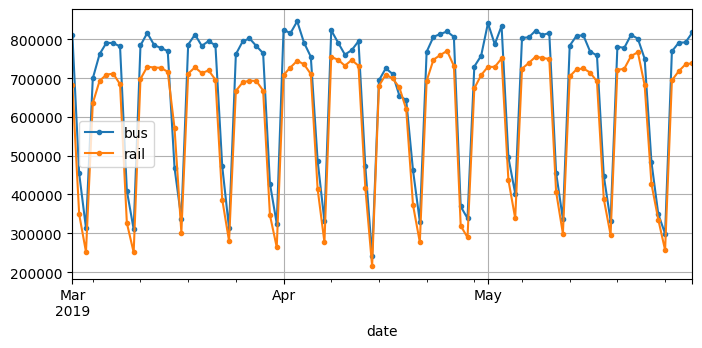

In [4]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [5]:
df[["bus", "rail"]].diff(7)

,bus,rail
date,,
2001-01-01,NaN,NaN
2001-01-02,NaN,NaN
2001-01-03,NaN,NaN
2001-01-04,NaN,NaN
2001-01-05,NaN,NaN
...,...,...
2021-11-26,-185547.0,-147508.0
2021-11-27,-33816.0,-89071.0
2021-11-28,-29200.0,-31707.0


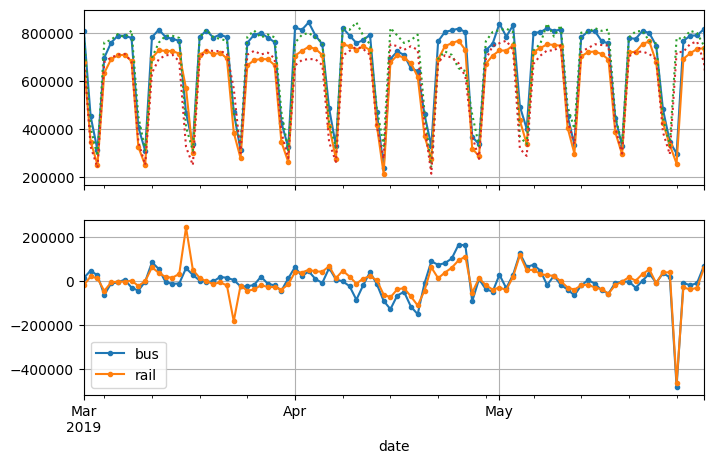

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
#mape
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

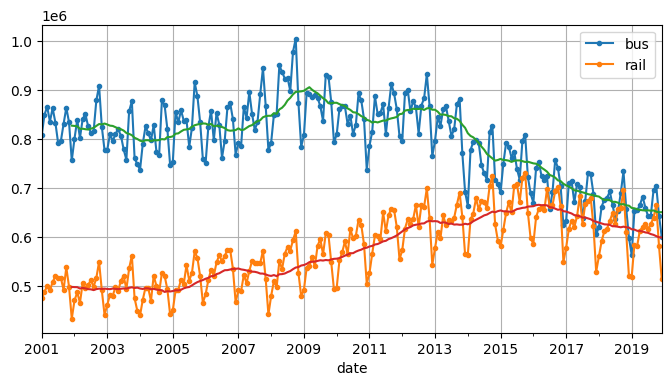

In [10]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean(numeric_only = True)
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

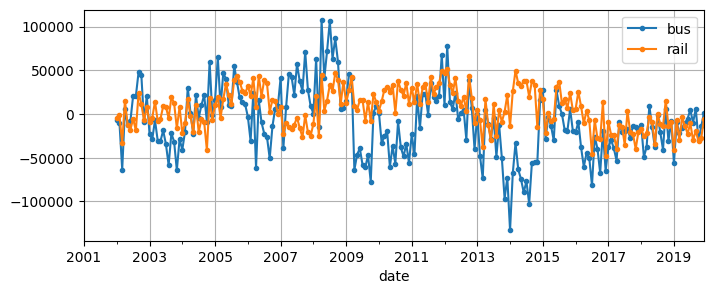

In [11]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

In [12]:
import sys
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [13]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # re

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              rail   No. Observations:                  151
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1857.203
Date:                           Fri, 19 Jul 2024   AIC                           3720.407
Time:                                   10:08:16   BIC                           3729.316
Sample:                               01-01-2019   HQIC                          3724.027
                                    - 05-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6491      0.052     12.586      0.000       0.548       0.750
ma.S.L7       -0.6651      0.076     -8.769      0.000      -0.814      -0.516
sigma2      1.167e+10   1.24e-12   9.41e+21      0.000    1.17e+10    1.17e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):              1003.69
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.98e+36. Standard errors may be unstable.
"""

In [15]:
y_pred[0]

427758.62641035335

In [16]:
df["rail"].loc["2019-06-01"]

379044

In [17]:
df["rail"].loc["2019-05-25"]

426932

In [18]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [19]:
mae

32040.720089453378

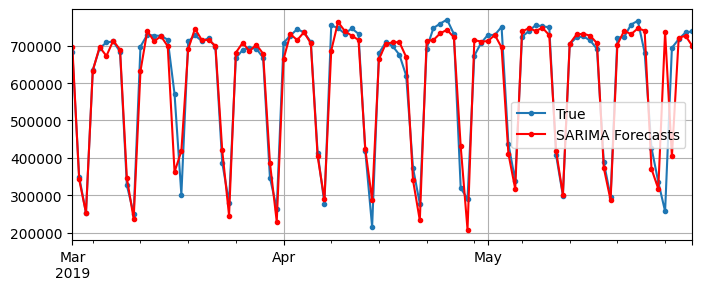

In [20]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

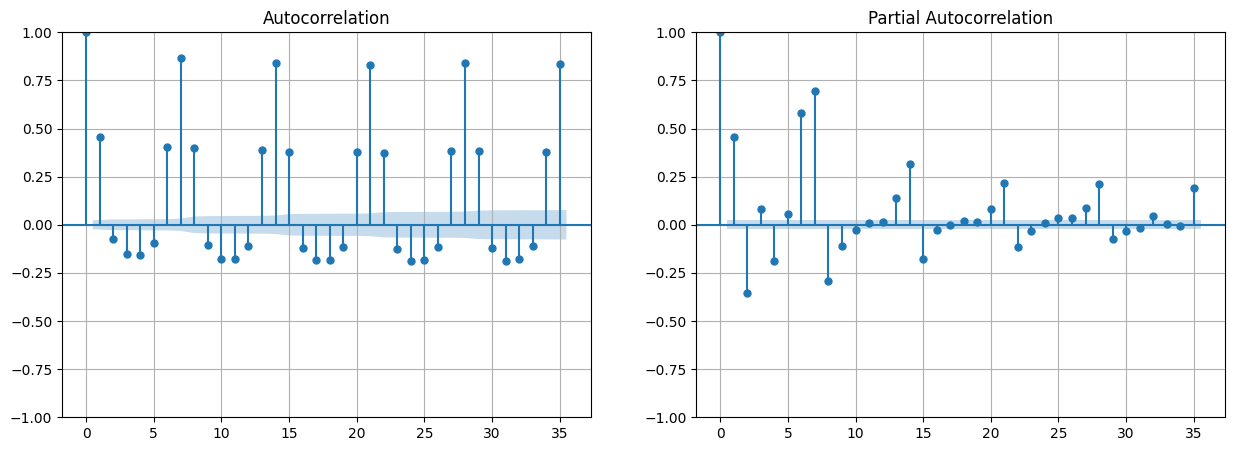

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [22]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [23]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [24]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [25]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [26]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [27]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [28]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [29]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 2s 18ms/step - loss: 0.0247 - mae: 0.1697 - val_loss: 0.0103 - val_mae: 0.1191
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0111 - mae: 0.1152 - val_loss: 0.0077 - val_mae: 0.1004
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0085 - mae: 0.0999 - val_loss: 0.0063 - val_mae: 0.0903
Epoch 4/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0071 - mae: 0.0894 - val_loss: 0.0056 - val_mae: 0.0827
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0064 - mae: 0.0837 - val_loss: 0.0047 - val_mae: 0.0756
Epoch 6/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0064 - mae: 0.0825 - val_loss: 0.0046 - val_mae: 0.0719
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0052 - mae: 0.0731 - val_loss: 0.0038 - val_mae: 0.0653
Epoch 8/500
33/33 [==============================] - 1s 11ms/step - loss: 0.

In [30]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 8ms/step - loss: 0.0021 - mae: 0.0364


36403.27602624893

# Using a Simple RNN

In [31]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [32]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [33]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 20ms/step - loss: 0.0162 - mae: 0.1588 - val_loss: 0.0164 - val_mae: 0.1566
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0162 - mae: 0.1610 - val_loss: 0.0167 - val_mae: 0.1458
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0164 - mae: 0.1604 - val_loss: 0.0172 - val_mae: 0.1392
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0163 - mae: 0.1579 - val_loss: 0.0164 - val_mae: 0.1546
Epoch 5/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0164 - mae: 0.1611 - val_loss: 0.0168 - val_mae: 0.1438
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0162 - mae: 0.1585 - val_loss: 0.0165 - val_mae: 0.1495
Epoch 7/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0162 - mae: 0.1584 - val_loss: 0.0168 - val_mae: 0.1429
Epoch 8/500
33/33 [==============================] - 0s 12ms/step - loss: 0.

102805.9795498848

In [34]:
0.1024 * 1e6

102400.0

In [35]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [36]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 20ms/step - loss: 0.0657 - mae: 0.2352 - val_loss: 0.0081 - val_mae: 0.0906
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0053 - mae: 0.0739 - val_loss: 0.0042 - val_mae: 0.0704
Epoch 3/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0043 - mae: 0.0629 - val_loss: 0.0023 - val_mae: 0.0439
Epoch 4/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0036 - mae: 0.0550 - val_loss: 0.0020 - val_mae: 0.0375
Epoch 5/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0038 - mae: 0.0594 - val_loss: 0.0035 - val_mae: 0.0656
Epoch 6/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0034 - mae: 0.0529 - val_loss: 0.0031 - val_mae: 0.0524
Epoch 7/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0576 - val_loss: 0.0025 - val_mae: 0.0518
Epoch 8/500
33/33 [==============================] - 1s 15ms/step - loss: 0.

29364.9323284626

In [37]:
0.0344 * 1e6

34400.0

In [38]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [39]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 20ms/step - loss: 0.0156 - mae: 0.1333 - val_loss: 0.0033 - val_mae: 0.0639
Epoch 2/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0039 - mae: 0.0621 - val_loss: 0.0023 - val_mae: 0.0463
Epoch 3/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0034 - mae: 0.0548 - val_loss: 0.0020 - val_mae: 0.0361
Epoch 4/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0019 - val_mae: 0.0339
Epoch 5/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0020 - val_mae: 0.0349
Epoch 6/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0028 - mae: 0.0452 - val_loss: 0.0019 - val_mae: 0.0351
Epoch 7/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0028 - mae: 0.0465 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 8/500
33/33 [==============================] - 1s 15ms/step - loss: 0.

28677.97017097473

# Deep RNNs

In [40]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [41]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 4s 48ms/step - loss: 0.0135 - mae: 0.1251 - val_loss: 0.0056 - val_mae: 0.0856
Epoch 2/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0053 - mae: 0.0706 - val_loss: 0.0023 - val_mae: 0.0407
Epoch 3/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0044 - mae: 0.0604 - val_loss: 0.0022 - val_mae: 0.0406
Epoch 4/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0040 - mae: 0.0558 - val_loss: 0.0028 - val_mae: 0.0498
Epoch 5/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0041 - mae: 0.0578 - val_loss: 0.0021 - val_mae: 0.0398
Epoch 6/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0040 - mae: 0.0580 - val_loss: 0.0024 - val_mae: 0.0428
Epoch 7/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0040 - mae: 0.0574 - val_loss: 0.0023 - val_mae: 0.0407
Epoch 8/500
33/33 [==============================] - 1s 34ms/step - loss: 0.

30940.20113348961

# Multivariate time series

In [42]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [43]:
df_mulvar

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,False,False,True
2001-01-02,0.780827,0.501952,False,False,True
2001-01-03,0.824923,0.536432,False,False,True
2001-01-04,0.870021,0.550011,False,False,True
2001-01-05,0.890426,0.557917,True,False,False
...,...,...,...,...,...
2021-11-26,0.257700,0.189694,True,False,False
2021-11-27,0.237839,0.187065,False,True,False
2021-11-28,0.184817,0.147830,False,False,True


In [44]:
import numpy as np
mulvar_train = df_mulvar["2016-01":"2018-12"].astype(np.float64)
mulvar_valid = df_mulvar["2019-01":"2019-05"].astype(np.float64)
mulvar_test = df_mulvar["2019-06":].astype(np.float64)

In [45]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [46]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [47]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 21ms/step - loss: 0.0089 - mae: 0.0972 - val_loss: 0.0031 - val_mae: 0.0657
Epoch 2/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0022 - mae: 0.0477 - val_loss: 0.0027 - val_mae: 0.0642
Epoch 3/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0020 - mae: 0.0457 - val_loss: 0.0010 - val_mae: 0.0329
Epoch 4/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0019 - mae: 0.0447 - val_loss: 7.5523e-04 - val_mae: 0.0281
Epoch 5/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0016 - mae: 0.0395 - val_loss: 7.8084e-04 - val_mae: 0.0297
Epoch 6/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0016 - mae: 0.0408 - val_loss: 0.0013 - val_mae: 0.0423
Epoch 7/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0013 - mae: 0.0364 - val_loss: 7.1686e-04 - val_mae: 0.0257
Epoch 8/500
33/33 [==============================] - 1s 16ms/ste

22755.909711122513

In [48]:
0.0237 * 1e6

23700.0

In [49]:

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 22ms/step - loss: 0.0377 - mae: 0.2024 - val_loss: 0.0045 - val_mae: 0.0765
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0039 - mae: 0.0629 - val_loss: 0.0014 - val_mae: 0.0375
Epoch 3/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0027 - mae: 0.0493 - val_loss: 0.0011 - val_mae: 0.0321
Epoch 4/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0471 - val_loss: 0.0021 - val_mae: 0.0522
Epoch 5/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0022 - mae: 0.0454 - val_loss: 0.0012 - val_mae: 0.0352
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0020 - mae: 0.0434 - val_loss: 0.0013 - val_mae: 0.0379
Epoch 7/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0020 - mae: 0.0438 - val_loss: 0.0013 - val_mae: 0.0399
Epoch 8/500
33/33 [==============================] - 1s 14ms/step - loss: 0.

25411.18487715721

In [50]:
#  extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [51]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 15ms/step
bus 26545
rail 24277


# Forecasting Several Steps Ahead

In [52]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 33ms/step


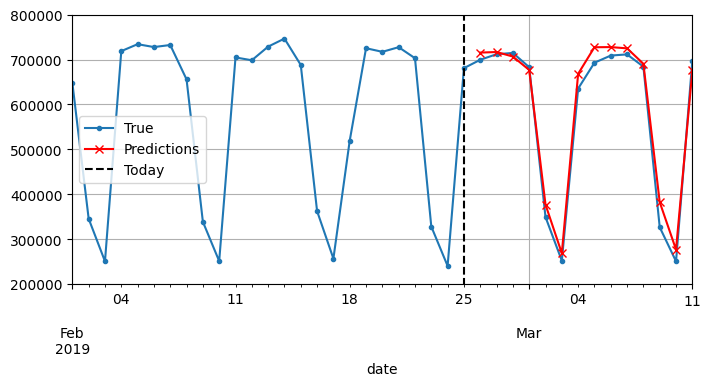

In [53]:


# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [54]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [55]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [56]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 24ms/step - loss: 0.1137 - mae: 0.3694 - val_loss: 0.0257 - val_mae: 0.1715
Epoch 2/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0184 - mae: 0.1472 - val_loss: 0.0120 - val_mae: 0.1192
Epoch 3/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0122 - mae: 0.1222 - val_loss: 0.0092 - val_mae: 0.1048
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0100 - mae: 0.1098 - val_loss: 0.0075 - val_mae: 0.0936
Epoch 5/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0087 - mae: 0.1011 - val_loss: 0.0064 - val_mae: 0.0861
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0078 - mae: 0.0939 - val_loss: 0.0055 - val_mae: 0.0809
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0071 - mae: 0.0888 - val_loss: 0.0048 - val_mae: 0.0749
Epoch 8/500
33/33 [==============================] - 0s 14ms/step - loss: 0.

33579.81890439987

In [57]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 168ms/step


In [58]:
Y_pred * 1e6

array([[714270.25, 717342.1 , 717402.94, 688602.06, 365163.88, 254174.38,
        635542.2 , 717800.94, 732656.9 , 724725.1 , 696812.3 , 369946.6 ,
        259526.38, 657632.56]], dtype=float32)

In [59]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [60]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [62]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [63]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [64]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [65]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 5s 91ms/step - loss: 0.0583 - mae: 0.2576 - val_loss: 0.0173 - val_mae: 0.1508
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0140 - mae: 0.1347 - val_loss: 0.0121 - val_mae: 0.1213
Epoch 3/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0105 - mae: 0.1132 - val_loss: 0.0107 - val_mae: 0.1050
Epoch 4/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0966 - val_loss: 0.0083 - val_mae: 0.0926
Epoch 5/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0068 - mae: 0.0850 - val_loss: 0.0066 - val_mae: 0.0803
Epoch 6/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0060 - mae: 0.0785 - val_loss: 0.0063 - val_mae: 0.0789
Epoch 7/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0055 - mae: 0.0737 - val_loss: 0.0058 - val_mae: 0.0746
Epoch 8/500
33/33 [==============================] - 1s 20ms/step - loss: 0.

45680.370181798935

In [66]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]

1/1 [==============================] - 0s 182ms/step


In [67]:
len(mulvar_valid.index[56 + 14: -1])

80

In [68]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 15ms/step
MAE for +1: 22,460
MAE for +2: 28,732
MAE for +3: 28,570
MAE for +4: 31,233
MAE for +5: 30,199
MAE for +6: 33,892
MAE for +7: 34,055
MAE for +8: 33,357
MAE for +9: 33,309
MAE for +10: 31,050
MAE for +11: 34,848
MAE for +12: 36,236
MAE for +13: 36,250
MAE for +14: 33,850


# Deep RNNs with Layer Norm

In [69]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [70]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [71]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 41ms/step - loss: 0.0662 - mae: 0.2588 - val_loss: 0.0178 - val_mae: 0.1362
Epoch 2/5
33/33 [==============================] - 1s 31ms/step - loss: 0.0135 - mae: 0.1336 - val_loss: 0.0138 - val_mae: 0.1137
Epoch 3/5
33/33 [==============================] - 1s 30ms/step - loss: 0.0105 - mae: 0.1137 - val_loss: 0.0110 - val_mae: 0.1021
Epoch 4/5
33/33 [==============================] - 1s 30ms/step - loss: 0.0091 - mae: 0.1024 - val_loss: 0.0101 - val_mae: 0.0969
Epoch 5/5
3/3 [==============================] - 0s 19ms/step - loss: 0.0088 - mae: 0.0911


91097.1462726593

# LSTMs

In [72]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [73]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 5s 52ms/step - loss: 0.0508 - mae: 0.2460 - val_loss: 0.0186 - val_mae: 0.1589
Epoch 2/5
33/33 [==============================] - 1s 29ms/step - loss: 0.0167 - mae: 0.1542 - val_loss: 0.0168 - val_mae: 0.1414
Epoch 3/5
33/33 [==============================] - 1s 28ms/step - loss: 0.0151 - mae: 0.1473 - val_loss: 0.0160 - val_mae: 0.1363
Epoch 4/5
33/33 [==============================] - 1s 30ms/step - loss: 0.0143 - mae: 0.1423 - val_loss: 0.0151 - val_mae: 0.1334
Epoch 5/5
3/3 [==============================] - 0s 22ms/step - loss: 0.0146 - mae: 0.1286


128594.32399272919

# GRUs

In [74]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [75]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 4s 57ms/step - loss: 0.0659 - mae: 0.2762 - val_loss: 0.0186 - val_mae: 0.1548
Epoch 2/5
33/33 [==============================] - 2s 50ms/step - loss: 0.0151 - mae: 0.1440 - val_loss: 0.0147 - val_mae: 0.1302
Epoch 3/5
33/33 [==============================] - 1s 29ms/step - loss: 0.0124 - mae: 0.1313 - val_loss: 0.0133 - val_mae: 0.1235
Epoch 4/5
33/33 [==============================] - 1s 29ms/step - loss: 0.0114 - mae: 0.1232 - val_loss: 0.0123 - val_mae: 0.1184
Epoch 5/5
3/3 [==============================] - 0s 18ms/step - loss: 0.0115 - mae: 0.1143


114300.437271595

<!-- Using One-Dimensional Convolutional Layers to Process Sequences
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125 -->

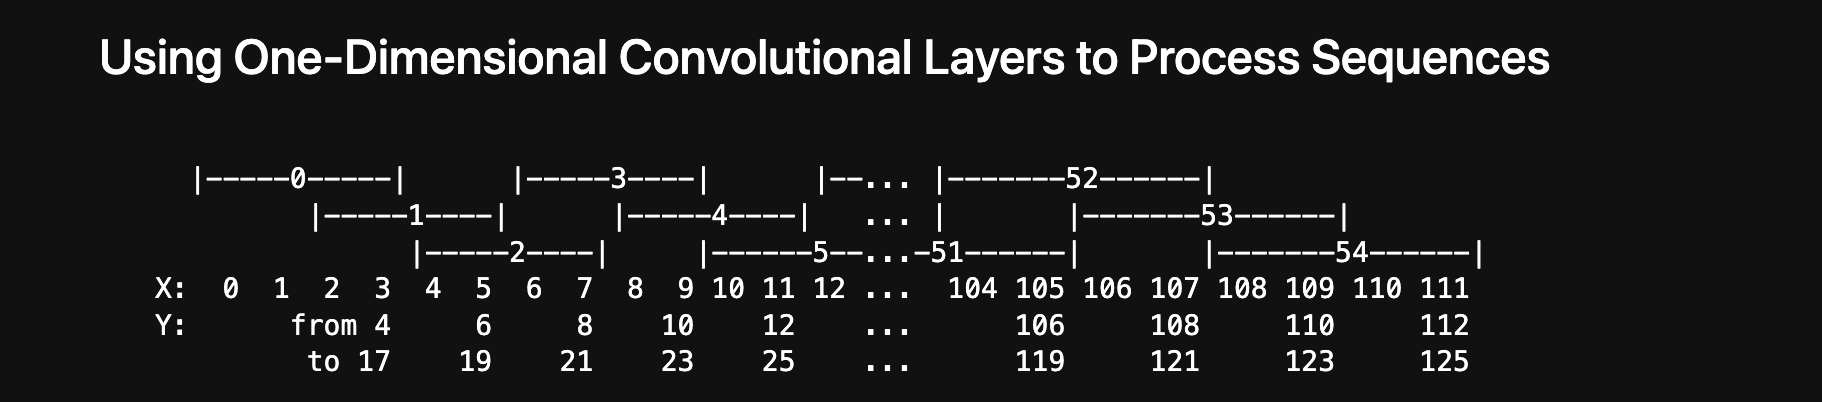

In [76]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [77]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 4s 55ms/step - loss: 0.0610 - mae: 0.2638 - val_loss: 0.0198 - val_mae: 0.1567
Epoch 2/5
31/31 [==============================] - 1s 36ms/step - loss: 0.0152 - mae: 0.1453 - val_loss: 0.0156 - val_mae: 0.1330
Epoch 3/5
31/31 [==============================] - 2s 59ms/step - loss: 0.0124 - mae: 0.1318 - val_loss: 0.0134 - val_mae: 0.1224
Epoch 4/5
31/31 [==============================] - 1s 34ms/step - loss: 0.0105 - mae: 0.1188 - val_loss: 0.0115 - val_mae: 0.1118
Epoch 5/5
1/1 [==============================] - 0s 79ms/step - loss: 0.0099 - mae: 0.1033


103281.55755996704

# WaveNet

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [ ]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)